## HOG

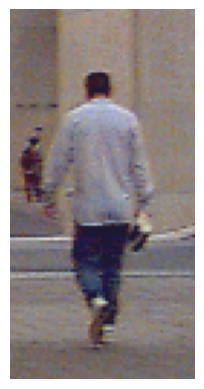

In [150]:
import os
import cv2
import matplotlib.pyplot as plt

pos_path = 'pos'
neg_path = 'neg'
win_size = (64, 128)

for f in os.listdir(pos_path):
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')):
        pos_img = cv2.imread(os.path.join(pos_path, f), cv2.IMREAD_COLOR_RGB)
        pos_img = cv2.resize(pos_img, win_size)
        break
        
plt.imshow(pos_img)
plt.axis('off')
plt.show()

In [151]:
import scipy
import numpy as np


def get_grad(img):
    dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
    dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)
    magnitude = np.sqrt(dx**2 + dy**2)

    max_R = np.logical_and(
        magnitude[:, :, 1] < magnitude[:, :, 0], magnitude[:, :, 2] < magnitude[:, :, 0]
    )
    max_G = np.logical_and(
        magnitude[:, :, 0] < magnitude[:, :, 1], magnitude[:, :, 2] < magnitude[:, :, 1]
    )
    max_B = np.logical_and(
        magnitude[:, :, 1] < magnitude[:, :, 2], magnitude[:, :, 0] < magnitude[:, :, 2]
    )
    
    max_dx = dx[:, :, 0] * max_R + dx[:, :, 1] * max_G + dx[:, :, 2] * max_B
    max_dy = dy[:, :, 0] * max_R + dy[:, :, 1] * max_G + dy[:, :, 2] * max_B
    max_magnitude = magnitude[:, :, 0] * max_R + magnitude[:, :, 1] * max_G + magnitude[:, :, 2] * max_B
    angle = np.arctan2(max_dy, max_dx)

    return max_magnitude, angle
    


pos_mag, pos_angle = get_grad(pos_img)

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)


In [152]:
import math


def get_hist(img, mag, angle, cell_size=8, hist_bins=9):
    height, width, _ = img.shape
    y_cells = np.int32(height / cell_size)
    x_cells = np.int32(width / cell_size)
    bin_size = np.pi / hist_bins  # bin size in radians

    histograms = np.zeros((y_cells, x_cells, hist_bins))

    for y_cell_idx in range(y_cells):
        for x_cell_idx in range(x_cells):
            cell_mag = mag[cell_size*y_cell_idx:cell_size*(y_cell_idx+1),
                           cell_size*x_cell_idx:cell_size*(x_cell_idx+1)]
            cell_angle = angle[cell_size*y_cell_idx:cell_size*(y_cell_idx+1),
                               cell_size*x_cell_idx:cell_size*(x_cell_idx+1)]
            cell_angle = np.mod(cell_angle, np.pi)  # keep angle in [0, pi)

            for i in range(cell_size):
                for j in range(cell_size):
                    el_mag = cell_mag[i, j]
                    el_angle = cell_angle[i, j]

                    bin_idx = int(el_angle // bin_size)
                    bin_center = bin_idx * bin_size + bin_size / 2

                    if el_angle < bin_center:
                        right_bin = bin_idx
                        left_bin = (bin_idx - 1) % hist_bins
                        dist_right = bin_center - el_angle
                        dist_left = bin_size - dist_right
                    else:
                        left_bin = bin_idx
                        right_bin = (bin_idx + 1) % hist_bins
                        dist_left = el_angle - bin_center
                        dist_right = bin_size - dist_left

                    total = dist_left + dist_right
                    w_left = dist_right / total
                    w_right = dist_left / total

                    histograms[y_cell_idx, x_cell_idx, left_bin] += el_mag * w_left
                    histograms[y_cell_idx, x_cell_idx, right_bin] += el_mag * w_right

    # Normalization in block
    e = math.pow(0.00001, 2)
    F = []
    for jj in range(y_cells - 1):
        for ii in range(x_cells - 1):
            H0 = histograms[jj, ii, :]
            H1 = histograms[jj, ii + 1, :]
            H2 = histograms[jj + 1, ii, :]
            H3 = histograms[jj + 1, ii + 1, :]
            H = np.concatenate((H0, H1, H2, H3))
            n = np.linalg.norm(H)
            Hn = H / np.sqrt(math.pow(n, 2) + e)
            F = np.concatenate((F, Hn))

    return F, histograms


# def get_hist(img, mag, angle, cell_size=8, hist_bins=9):
#     height, width, _ = img.shape
#     y_cells = np.int32(height / cell_size)
#     x_cells = np.int32(width / cell_size)
#     hist_bin_width = np.pi / hist_bins
    
#     histograms = np.zeros((y_cells, x_cells, hist_bins))
    
#     for y_cell_idx in range(y_cells):
#         for x_cell_idx in range(x_cells):
#             cell_mag =  mag[cell_size*y_cell_idx:cell_size*(y_cell_idx+1),
#                             cell_size*x_cell_idx:cell_size*(x_cell_idx+1)]
#             cell_angle =  angle[cell_size*y_cell_idx:cell_size*(y_cell_idx+1),
#                                 cell_size*x_cell_idx:cell_size*(x_cell_idx+1)]
#             cell_angle[np.where(cell_angle < 0)] += np.pi
            
#             for mag_row, angle_row in zip(cell_mag, cell_angle):
#                 for el_mag, el_angle in zip(mag_row, angle_row):
#                     bin_idx_lower = int(el_angle / hist_bin_width)
#                     bin_idx_rest = el_angle % hist_bin_width
#                     is_lower_half = bin_idx_rest < 0.5
#                     if bin_idx_lower == hist_bins:
#                         is_lower_half = False
#                         bin_idx_lower -= 1
#                     elif is_lower_half and bin_idx_lower:  # 1 <= bin_idx_lower <= bins-1
#                         bin_idx_lower -= 1
#                     elif is_lower_half:  # bin_idx_lower = 0
#                         bin_idx_lower = hist_bins - 1
                    
#                     safe_angle = el_angle + np.pi if (bin_idx_lower == hist_bins - 1 and is_lower_half) else el_angle
#                     bin_center_lower = hist_bin_width * bin_idx_lower + hist_bin_width / 2
#                     bin_lower_diff = safe_angle - bin_center_lower

#                     bin_center_upper = hist_bin_width * ((bin_idx_lower + 1) if bin_idx_lower < hist_bin_width - 1 else 0) + hist_bin_width / 2
#                     bin_upper_diff = bin_center_upper - safe_angle
                    
#                     mag_upper = el_mag * (bin_lower_diff / hist_bin_width)
#                     mag_lower = el_mag * (bin_upper_diff / hist_bin_width)
                    
#                     histograms[y_cell_idx, x_cell_idx, bin_idx_lower] += mag_lower
#                     histograms[y_cell_idx, x_cell_idx, (bin_idx_lower + 1) if bin_idx_lower < hist_bin_width - 1 else 0] += mag_upper
                    
#     # Normalization in block
#     e = math.pow(0.00001, 2)
#     F = []
#     for jj in range(y_cells - 1):
#         for ii in range(x_cells - 1):
#             H0 = histograms[jj, ii, :]
#             H1 = histograms[jj, ii + 1, :]
#             H2 = histograms[jj + 1, ii, :]
#             H3 = histograms[jj + 1, ii + 1, :]
#             H = np.concatenate((H0, H1, H2, H3))
#             n = np.linalg.norm(H)
#             Hn = H / np.sqrt(math.pow(n, 2) + e)
#             F = np.concatenate((F, Hn))
            
#     return F, histograms


pos_desc, pos_hists = get_hist(pos_img, pos_mag, pos_angle)

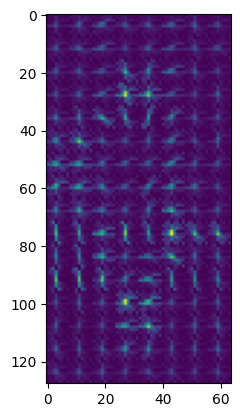

In [153]:
def HOGpicture(w, bs=8):  # w - histograms , bs - cell size (8)
    bim1 = np.zeros((bs, bs))
    bim1[np.round(bs // 2) : np.round(bs // 2) + 1, :] = 1
    bim = np.zeros(bim1.shape + (9,))
    bim[:, :, 0] = bim1
    for i in range(0, 9):  # 2:9 ,
        bim[:, :, i] = scipy.ndimage.rotate(bim1, -i * 20, order=0, mode='nearest', reshape=False) / 255

    Y, X, Z = w.shape
    w[w < 0] = 0
    im = np.zeros((bs * Y, bs * X))

    for i in range(Y):
        iisl = (i) * bs
        iisu = (i + 1) * bs
        for j in range(X):
            jjsl = j * bs
            jjsu = (j + 1) * bs
            for k in range(9):
                im[iisl:iisu, jjsl:jjsu] += bim[:, :, k] * w[i, j, k]

    return im


pos_hist_img = HOGpicture(pos_hists)
plt.imshow(pos_hist_img)
plt.show()



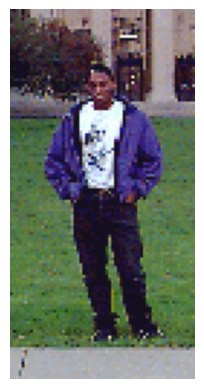

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)


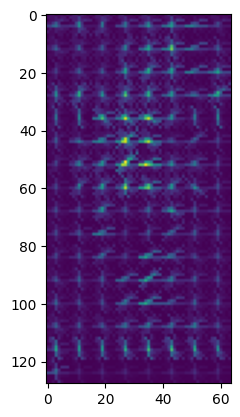

[0.34503374 0.16013222 0.10374708 0.13106974 0.13718808 0.0910798
 0.08984893 0.19346576 0.19455486 0.16069788]
3780


In [154]:
def hog_descriptor(img, vis=False):
    if img.shape != (64, 128):
        img = cv2.resize(img, (64, 128))
    if vis:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    mag, angle = get_grad(img)
    desc, hists = get_hist(img, mag, angle)
    hist_img = HOGpicture(hists)
    if vis:
        plt.imshow(hist_img)
        plt.show()
    
    return desc

img = cv2.imread(os.path.join(pos_path, 'per00060.ppm'), cv2.IMREAD_COLOR_RGB)
img_desc = hog_descriptor(img, vis=True)

print(img_desc[:10])
print(len(img_desc))

# SVM

In [ ]:
import random

pos_path = 'pos'
neg_path = 'neg'

pos_files = os.listdir(pos_path)
neg_files = os.listdir(neg_path)



random.shuffle(pos_files)
random.shuffle(neg_files)

train_size = 100
val_size = 100
test_size = 100

train_HOG = np.zeros([2 * 100, 3781], np.float32)
for i, (pos_f, neg_f) in enumerate(zip(pos_files[:train_size], neg_files[:train_size])):
    if pos_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')) and neg_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')):
        img = cv2.imread(os.path.join(pos_path, pos_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        train_HOG[i, 0] = 1
        train_HOG[i, 1:] = hog_desc
        img = cv2.imread(os.path.join(neg_path, neg_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        train_HOG[i + 100, 0] = 0
        train_HOG[i + 100, 1:] = hog_desc
        
train_labels = train_HOG[:, 0]
train_data = train_HOG[:, 1:]

test_HOG = np.zeros([2 * 100, 3781], np.float32)
for i, (pos_f, neg_f) in enumerate(zip(pos_files[train_size:train_size+test_size], neg_files[train_size:train_size+test_size])):
    if pos_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')) and neg_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')):
        img = cv2.imread(os.path.join(pos_path, pos_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        test_HOG[i, 0] = 1
        test_HOG[i, 1:] = hog_desc
        img = cv2.imread(os.path.join(neg_path, neg_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        test_HOG[i + 100, 0] = 0
        test_HOG[i + 100, 1:] = hog_desc
        
test_labels = test_HOG[:, 0]
test_data = test_HOG[:, 1:]

val_HOG = np.zeros([2 * 100, 3781], np.float32)
for i, (pos_f, neg_f) in enumerate(zip(pos_files[train_size+test_size:train_size+test_size+val_size], neg_files[train_size+test_size:train_size+test_size+val_size])):
    if pos_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')) and neg_f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', 'ppm')):
        img = cv2.imread(os.path.join(pos_path, pos_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        val_HOG[i, 0] = 1
        val_HOG[i, 1:] = hog_desc
        img = cv2.imread(os.path.join(neg_path, neg_f), cv2.IMREAD_COLOR_RGB)
        hog_desc = hog_descriptor(img)
        val_HOG[i + 100, 0] = 0
        val_HOG[i + 100, 1:] = hog_desc
        
val_labels = val_HOG[:, 0]
val_data = val_HOG[:, 1:]

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)


In [168]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(train_data, train_labels)


SVC(kernel='linear')

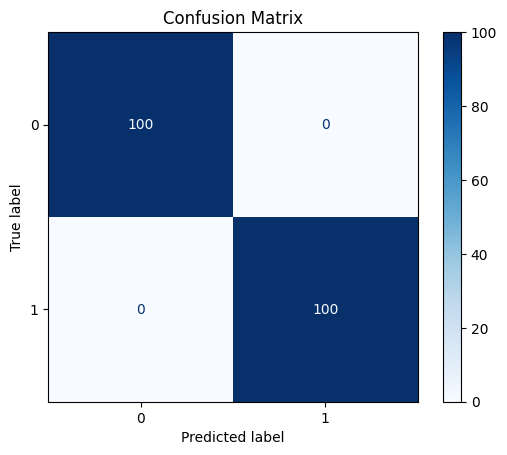

TP: 100, TN: 100, FP: 0, FN: 0


In [169]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def asses_results(real_labels, predicted_labels):
    cm = confusion_matrix(real_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    TN, FP, FN, TP = cm.ravel()
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

lp = clf.predict(train_data)
asses_results(train_labels, lp)

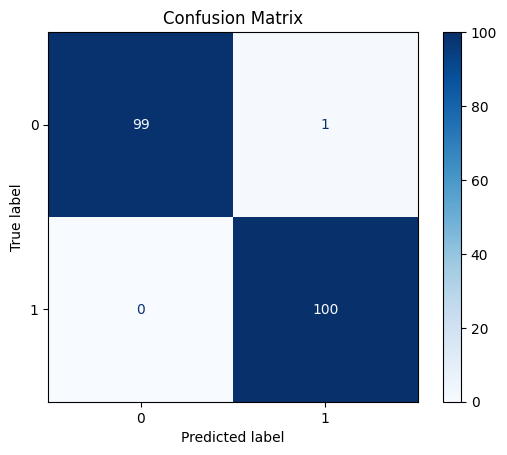

TP: 100, TN: 99, FP: 1, FN: 0


In [170]:
lp = clf.predict(val_data)
asses_results(val_labels, lp)

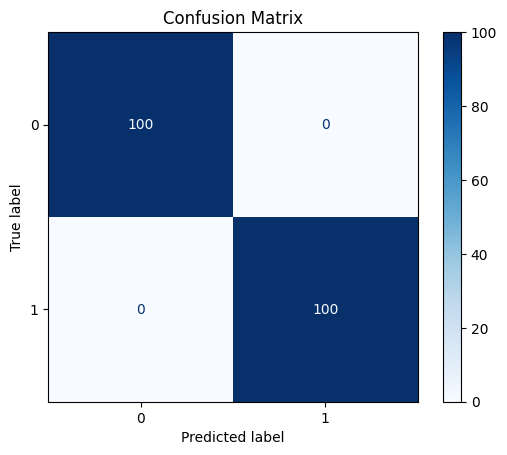

TP: 100, TN: 100, FP: 0, FN: 0


In [171]:
lp = clf.predict(test_data)
asses_results(test_labels, lp)

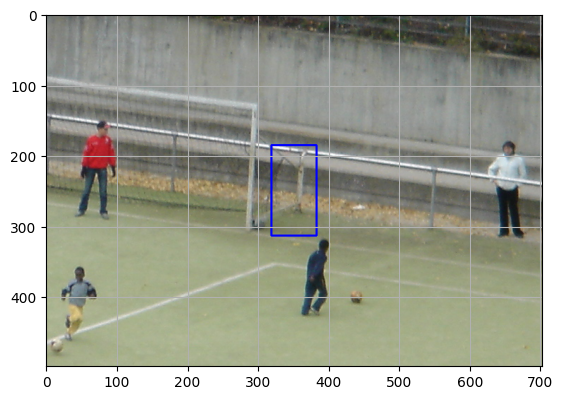

[562 398]


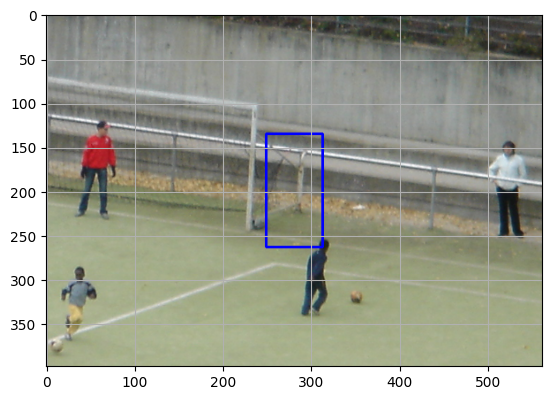

In [172]:
from copy import copy

win_size = (64, 128)

# Wyświetlanie na środku obrazu rozmiaru okna
def show_window_on_image(img):
    img_rect = copy(img)
    cv2.rectangle(img_rect, 
                (img_rect.shape[1] // 2 - win_size[0] // 2, img_rect.shape[0] // 2 - win_size[1] // 2),
                (img_rect.shape[1] // 2 + int(np.ceil(win_size[0] / 2)), img_rect.shape[0] // 2 + int(np.ceil(win_size[1] / 2))),
                (0, 0, 255), 2)
    plt.imshow(img_rect)
    plt.grid(True)
    plt.show()

def rescale_for_window_size(img_path, coef):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)
    show_window_on_image(img)
    new_size = np.flip((np.array(img.shape[:2]) * coef).astype(int))
    print(new_size)
    img = cv2.resize(img, new_size)
    show_window_on_image(img)
    
    return img

test_img1 = rescale_for_window_size('testImage1.png', 0.8)



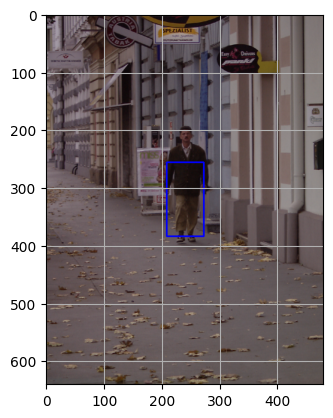

[268 358]


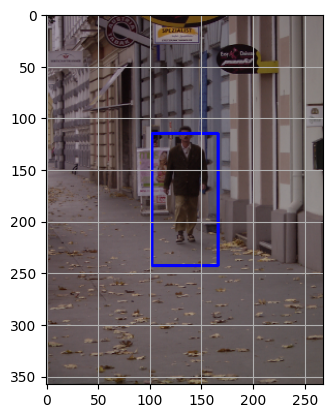

In [173]:
test_img2 = rescale_for_window_size('testImage2.png', 0.56)


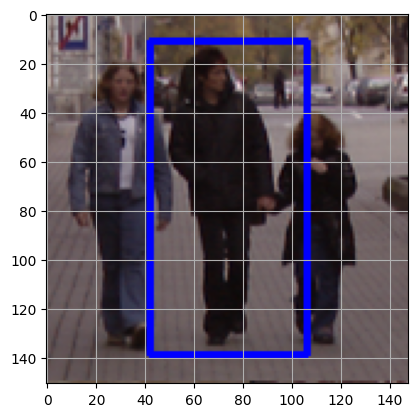

[148 151]


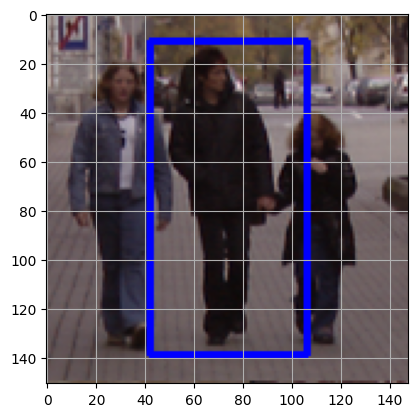

In [174]:
test_img3 = rescale_for_window_size('testImage3.png', 1)

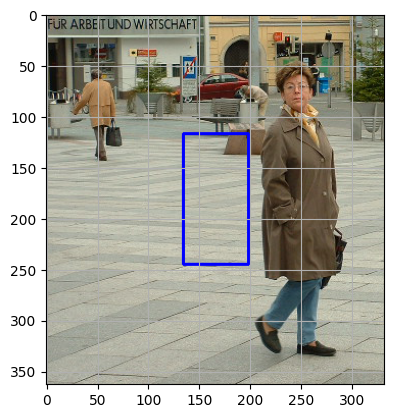

[132 145]


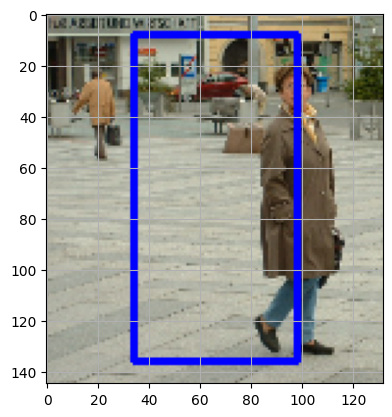

In [175]:
test_img4 = rescale_for_window_size('testImage4.png', 0.4)

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15

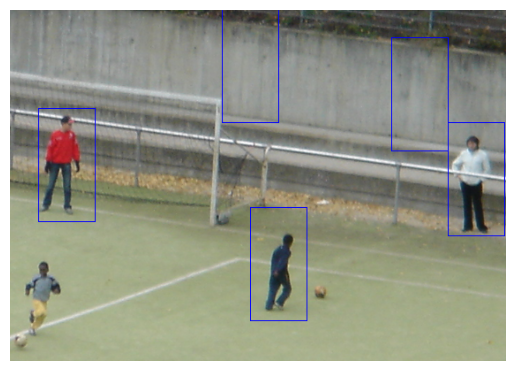

In [183]:
def seek_people(img, clf, step=8, win_size=(64,128)):
    rect_img = copy(img)
    
    height, width, _ = img.shape
    for y in range(0, height - win_size[1], step):
        for x in range(0, width - win_size[0], step):
            win = img[y:y+128, x:x+64]
            hog = hog_descriptor(win)
            res = clf.predict([hog])
            if res:
                rect_img = cv2.rectangle(rect_img, (x, y), (x+64, y+128), (0, 0, 255), 1)

    plt.imshow(rect_img)
    plt.axis('off')
    plt.show()
    
seek_people(test_img1, clf, step=16)

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15

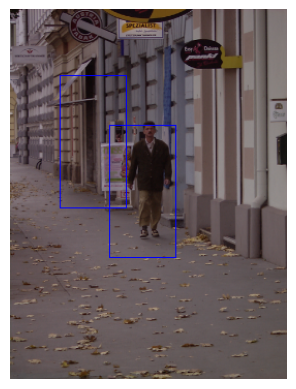

In [186]:
seek_people(test_img2, clf, step=16)

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15

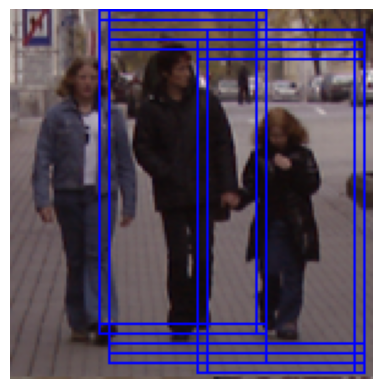

In [187]:
seek_people(test_img3, clf, step=4)

C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:7: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dy = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 0)
C:\Users\roman\AppData\Local\Temp\ipykernel_15900\1469832611.py:6: DeprecationWarning: Please import `convolve1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  dx = scipy.ndimage.filters.convolve1d(np.int32(img), np.array([-1, 0, 1]), 1)
C:\Users\roman\AppData\Local\Temp\ipykernel_15

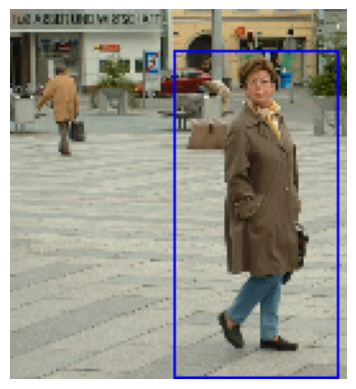

In [188]:
seek_people(test_img4, clf, step=16)